In [1]:
import numpy as np
import h5py
import torch
from haar_noising_script import apply_haar_scrambling

QG_channel = 1
filename = f"../../../data/QG{QG_channel}_normalized_16x16_100k"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 100

encoded_data_load = torch.load(f"../../../data/Q{QG_channel}_16x16_1k_encoded.pt")
print(encoded_data_load.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data_load), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

C:\Users\realc\AppData\Local\Temp\ipykernel_16848\4263250224.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_data_load = torch.load(f"../../../data/Q{QG_channel

torch.Size([1000, 8, 8, 4])
torch.Size([100, 8, 8, 4])


C:\Users\realc\AppData\Local\Temp\ipykernel_16848\4263250224.py:16: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:305.)
  scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)


In [7]:
import import_ipynb
import numpy as np
import h5py
import torch
from angle_encoding_script import angle_encoding
from haar_noising_script import apply_haar_scrambling

QG_channel = 1
filename = f"../../../data/QG{QG_channel}_normalized_16x16_100k"
with h5py.File(filename, "r") as f:
    data_X = np.array(f['X'])
    labels_y = np.array(f['y']) 

data_X_quarks = data_X[labels_y == 0]  # quarks i think
data_X_gluons = data_X[labels_y == 1]  # gluons


num_samples = 100

data_X = data_X_quarks
encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

torch.Size([100, 8, 8, 4])
torch.Size([100, 8, 8, 4])


Epoch [1/100], Loss: 1.0229, Val Loss: 0.6664, FID: 168.9238
Epoch [2/100], Loss: 0.6717, Val Loss: 0.3736, FID: 93.6816
Epoch [3/100], Loss: 0.3840, Val Loss: 0.1498, FID: 36.0372
Epoch [4/100], Loss: 0.1630, Val Loss: 0.0477, FID: 9.5273
Epoch [5/100], Loss: 0.0609, Val Loss: 0.0901, FID: 20.0794
Epoch [6/100], Loss: 0.1020, Val Loss: 0.1526, FID: 35.9798
Epoch [7/100], Loss: 0.1590, Val Loss: 0.1491, FID: 35.1677
Epoch [8/100], Loss: 0.1494, Val Loss: 0.1020, FID: 23.2658
Epoch [9/100], Loss: 0.1005, Val Loss: 0.0545, FID: 11.2985
Epoch [10/100], Loss: 0.0610, Val Loss: 0.0316, FID: 5.6201
Epoch [11/100], Loss: 0.0399, Val Loss: 0.0310, FID: 5.5932
Epoch [12/100], Loss: 0.0433, Val Loss: 0.0378, FID: 7.3800
Epoch [13/100], Loss: 0.0516, Val Loss: 0.0417, FID: 8.3978
Epoch [14/100], Loss: 0.0561, Val Loss: 0.0399, FID: 7.9063
Epoch [15/100], Loss: 0.0453, Val Loss: 0.0338, FID: 6.2832
Epoch [16/100], Loss: 0.0402, Val Loss: 0.0258, FID: 4.1590
Epoch [17/100], Loss: 0.0301, Val Loss: 

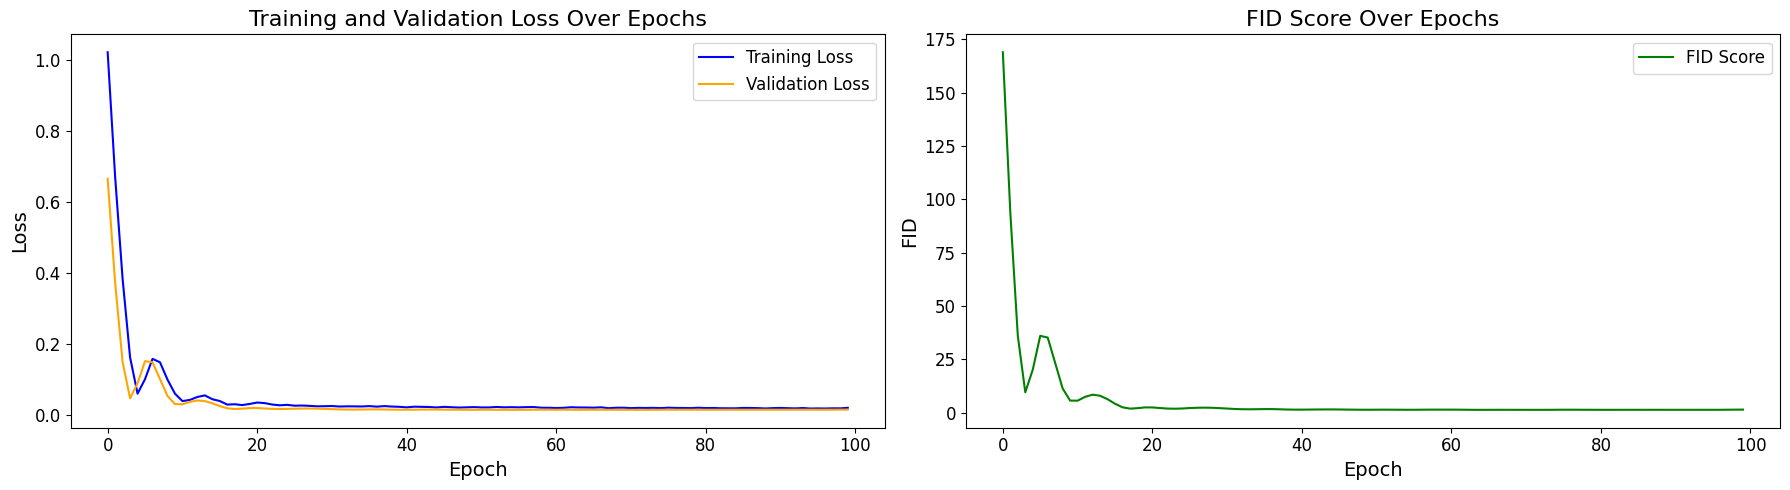

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg
import pennylane as qml

encoded_data = encoded_data_load

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data[:num_samples], scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class QuantumDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(QuantumDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, n_qubits)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers)
        self.fc2 = nn.Linear(n_qubits, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.quantum_layer(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

n_layers = 6
input_dim = 8 * 8 * 4 
hidden_dim = 128
output_dim = input_dim  

model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
loss_values = []
val_loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

        mu1, sigma1 = calculate_statistics(data_X[:len(decoded_data)])
        mu2, sigma2 = calculate_statistics(decoded_data)
        fid = calculate_fid(mu1, sigma1, mu2, sigma2)
        fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, FID: {fid:.4f}')

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(fid_scores, label='FID Score', color='green')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('FID', fontsize=14)
plt.title('FID Score Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

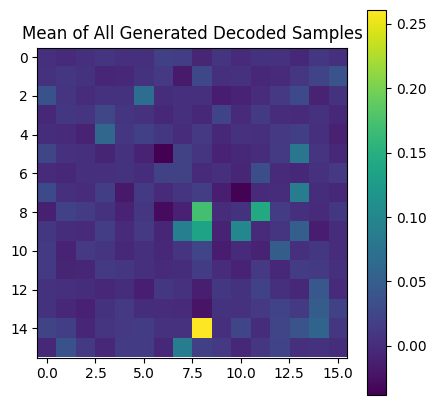

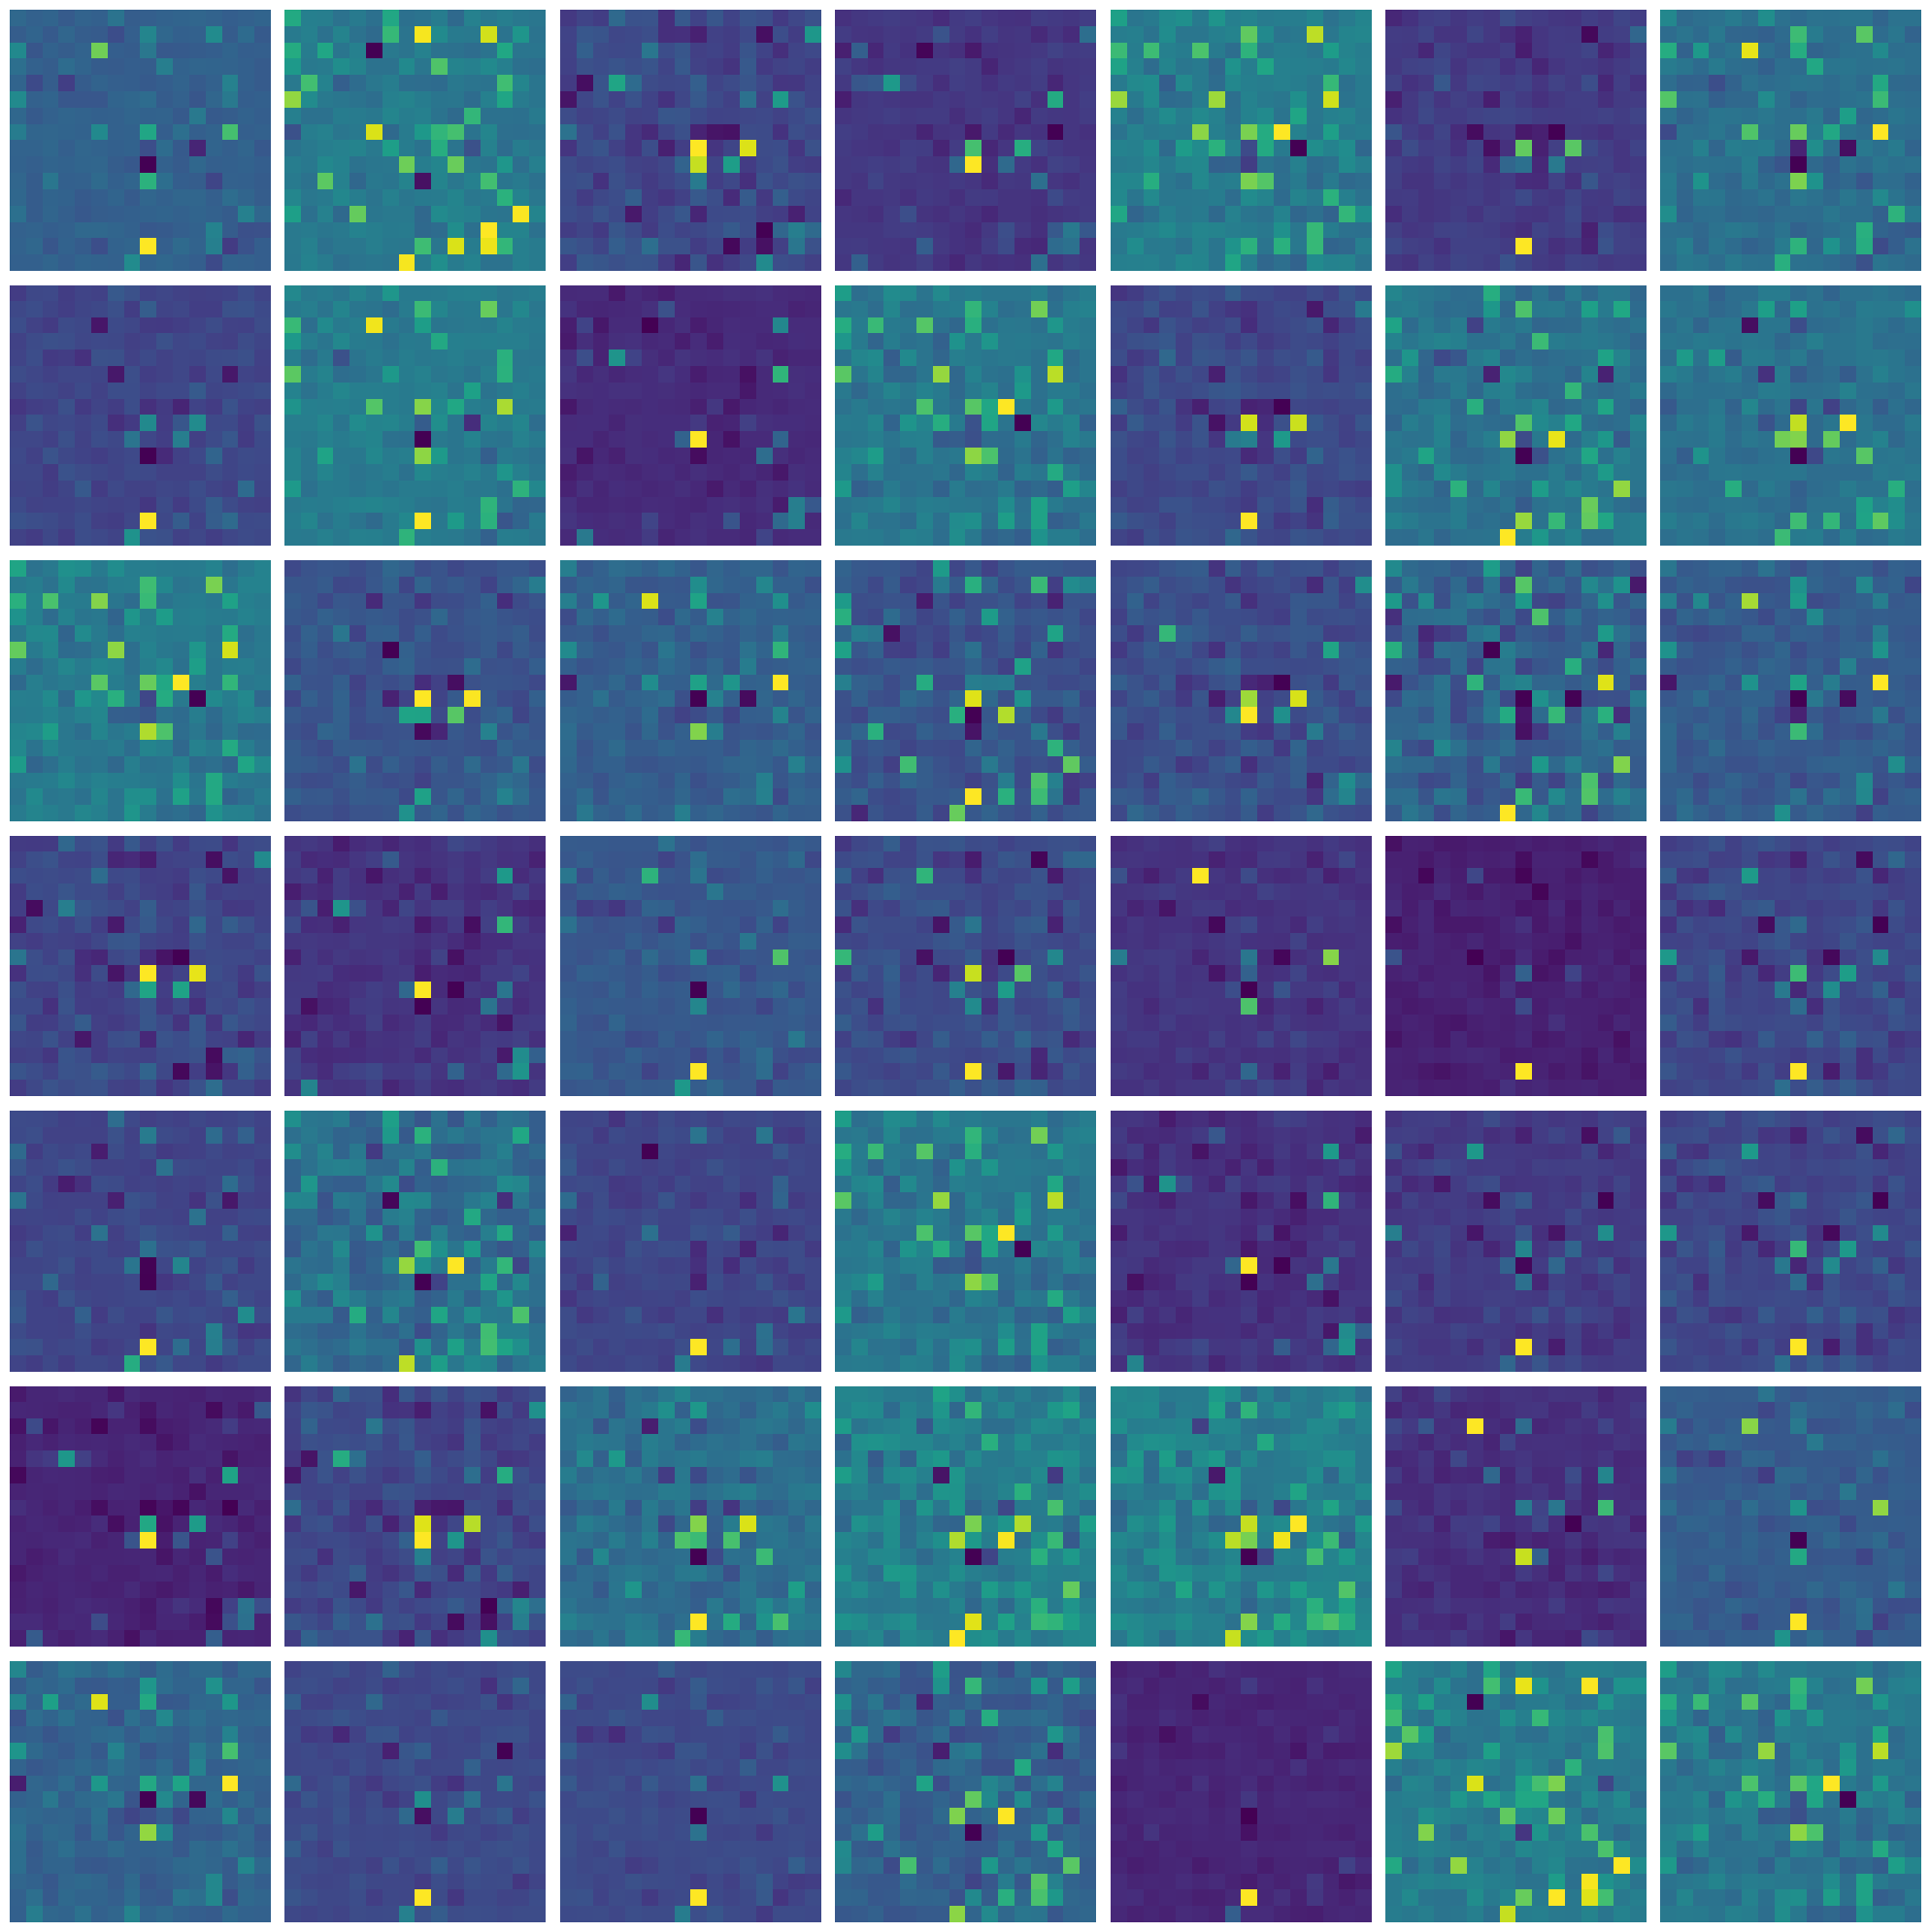

In [9]:
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        random_noise = torch.randn(num_images, input_dim)
        generated_data = model(random_noise)
        generated_data = flip(generated_data.view(num_images, 8, 8, 4).detach().numpy())
        decoded_images = decode(generated_data) 
        
        # for i in range(num_images):
        #     fig, axes = plt.subplots(1, 5, figsize=(10, 2))

        #     for qubit in range(4):
        #         im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
        #         axes[qubit].set_title(f"Encoded {qubit+1}")
        #         fig.colorbar(im, ax=axes[qubit])

        #     im = axes[4].imshow(decoded_images[i], cmap='viridis')
        #     axes[4].set_title("Decoded")
        #     fig.colorbar(im, ax=axes[4])
            
        #     plt.tight_layout()
        #     plt.show()

    return decoded_images

def plot_mean_decoded_images(decoded_images):
    mean_image = np.mean(decoded_images, axis=0)

    plt.figure(figsize=(5, 5))
    plt.imshow(mean_image, cmap='viridis')
    plt.title("Mean of All Generated Decoded Samples")
    plt.colorbar()
    plt.show()

def plot_all_decoded_images(decoded_images, grid_size=(10, 10)):
    num_images = decoded_images.shape[0]
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))

    image_idx = 0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if image_idx < num_images:
                axes[i, j].imshow(decoded_images[image_idx], cmap='viridis')
                axes[i, j].axis('off')
                image_idx += 1
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

num_samples_to_generate = 49
new_images = generate_new_images(model, num_samples_to_generate)
plot_mean_decoded_images(new_images)
plot_all_decoded_images(new_images, grid_size=(7, 7))

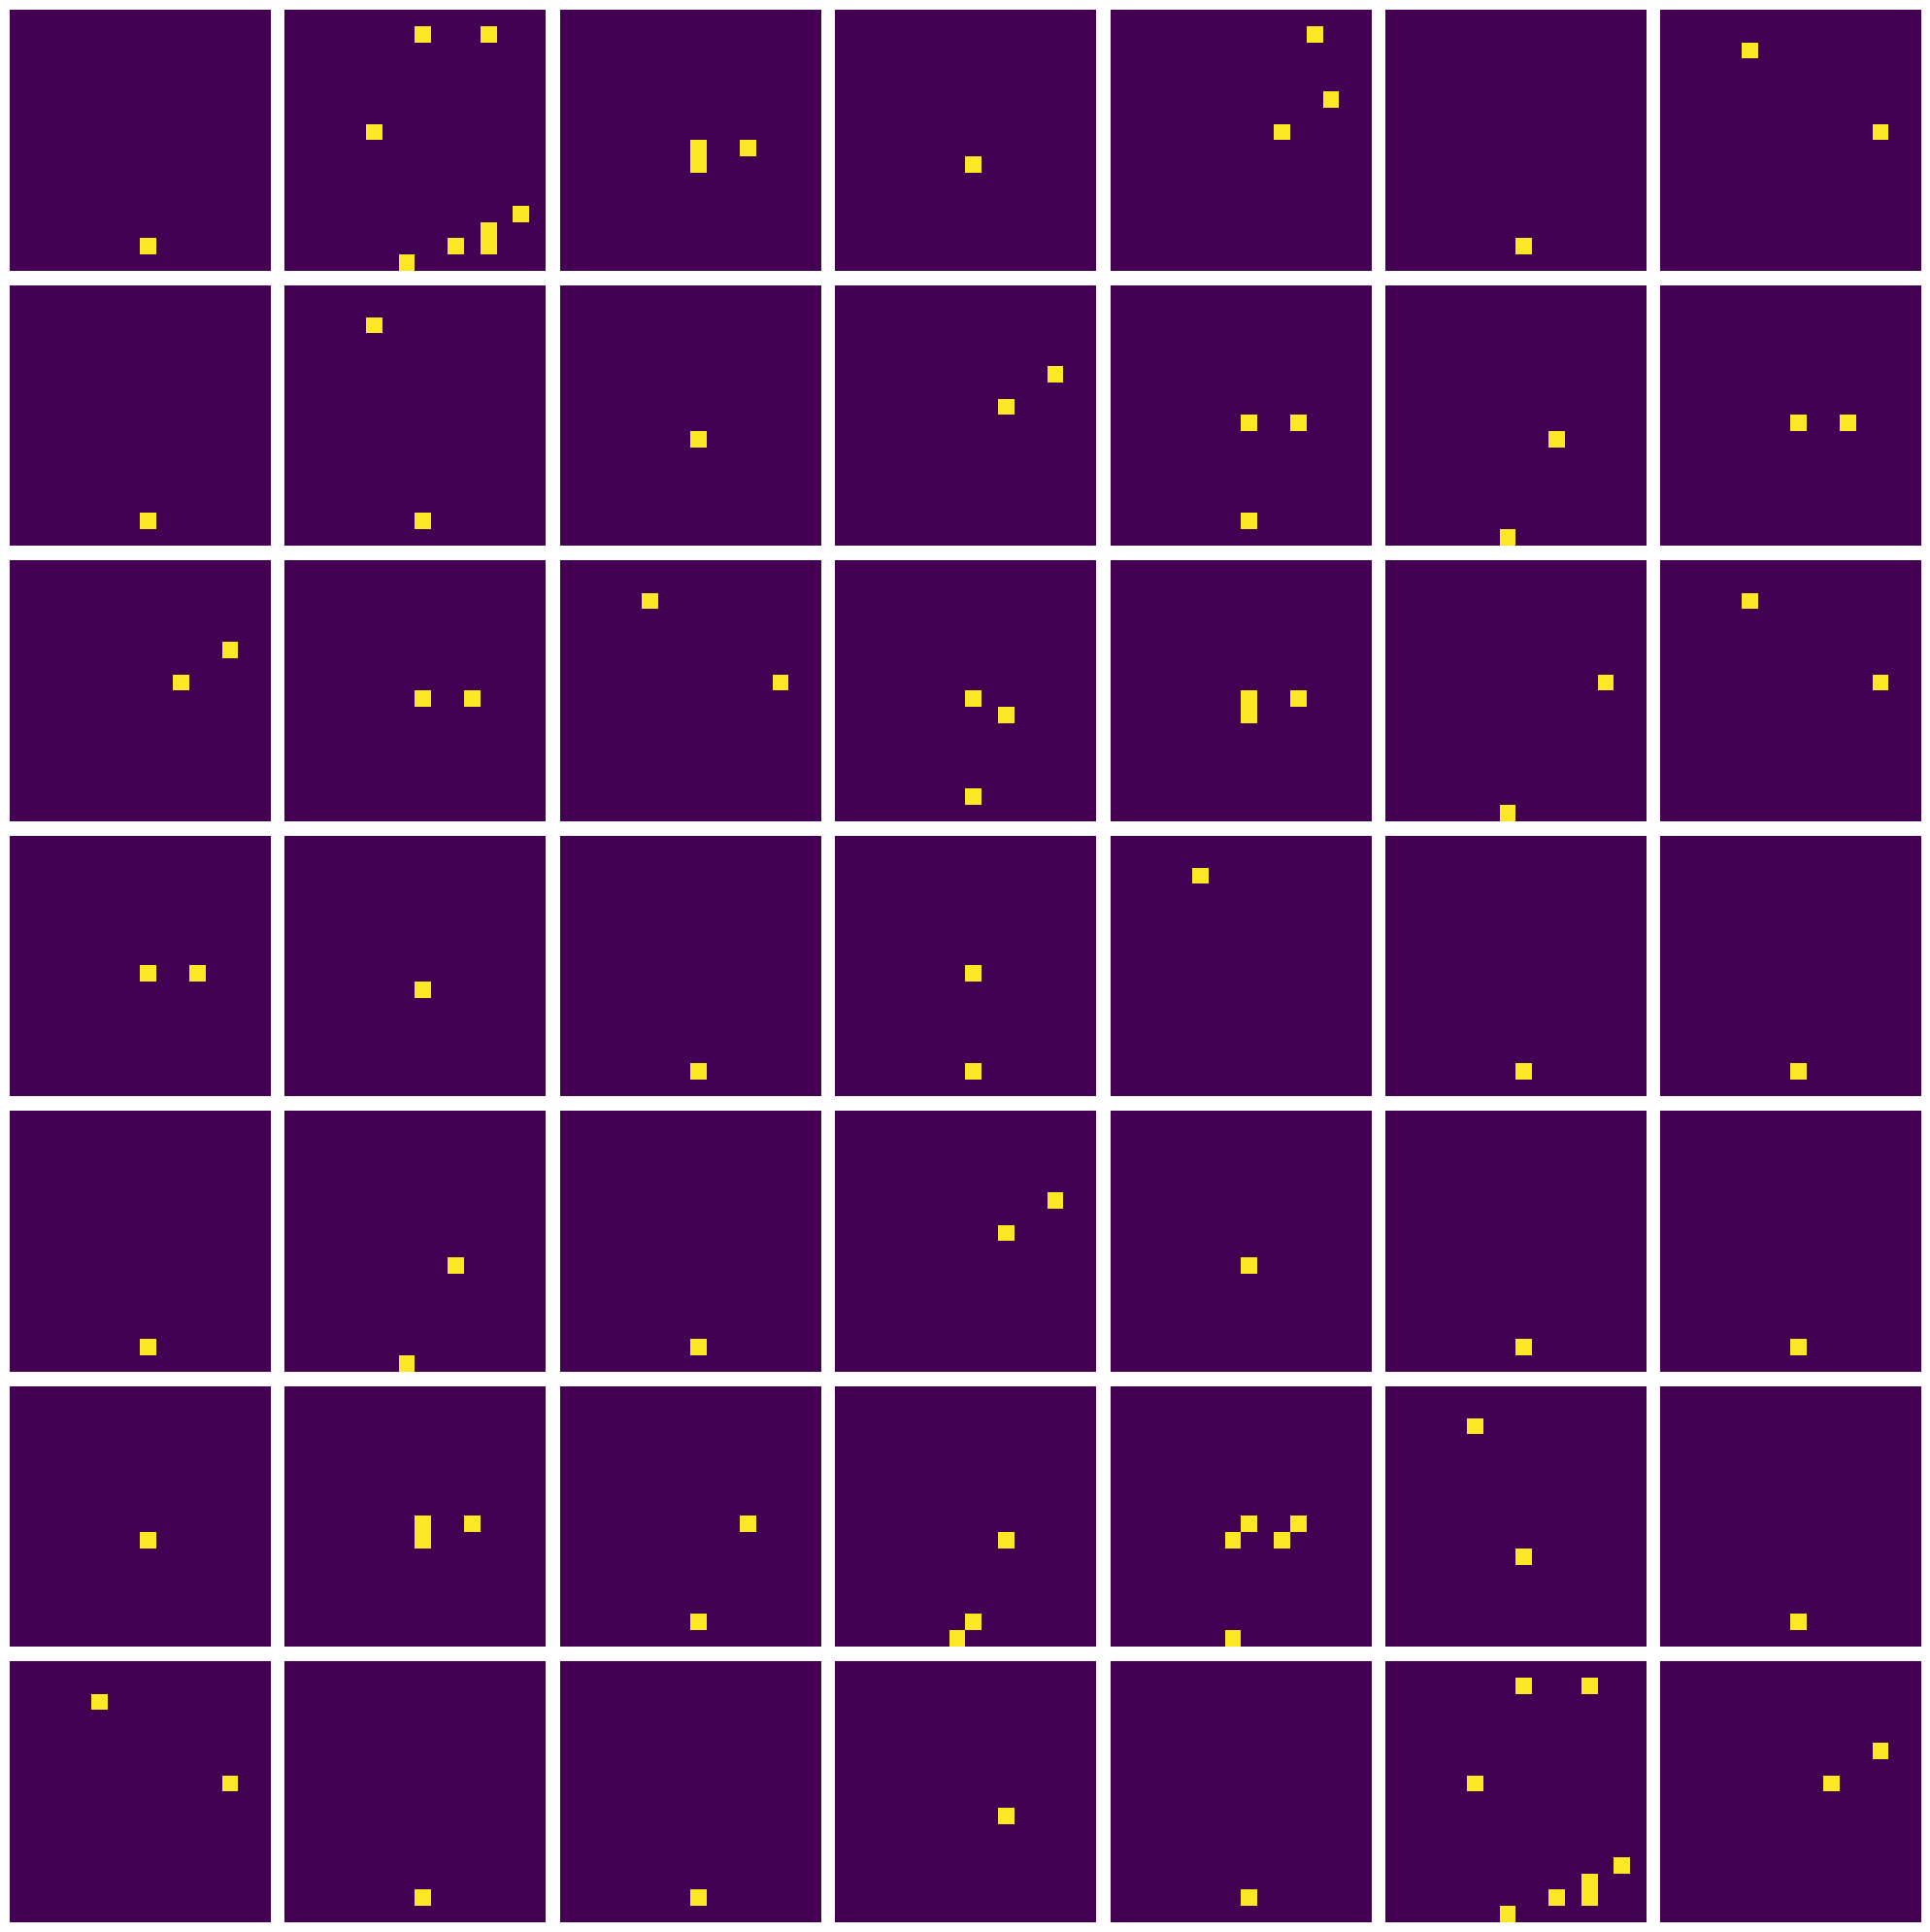

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decoded_images_without_noise(decoded_images, grid_size=(4, 4)):
    num_images = decoded_images.shape[0]
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if (i * grid_size[1] + j) < num_images:
                image = decoded_images[i * grid_size[1] + j]

                median_val = np.median(image)
                max_val = np.max(image)

                image_without_noise = np.where(image > (max_val-median_val)*4/5 + median_val, 1.0, 0.0)

                axes[i, j].imshow(image_without_noise, cmap='viridis')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

plot_decoded_images_without_noise(new_images, grid_size=(7, 7))